C:\Users\User\AppData\Local\Temp\ipykernel_5376\2824428189.py:209: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  equity_df = pd.DataFrame(all_runs_equity_curves).T.fillna(method='ffill')


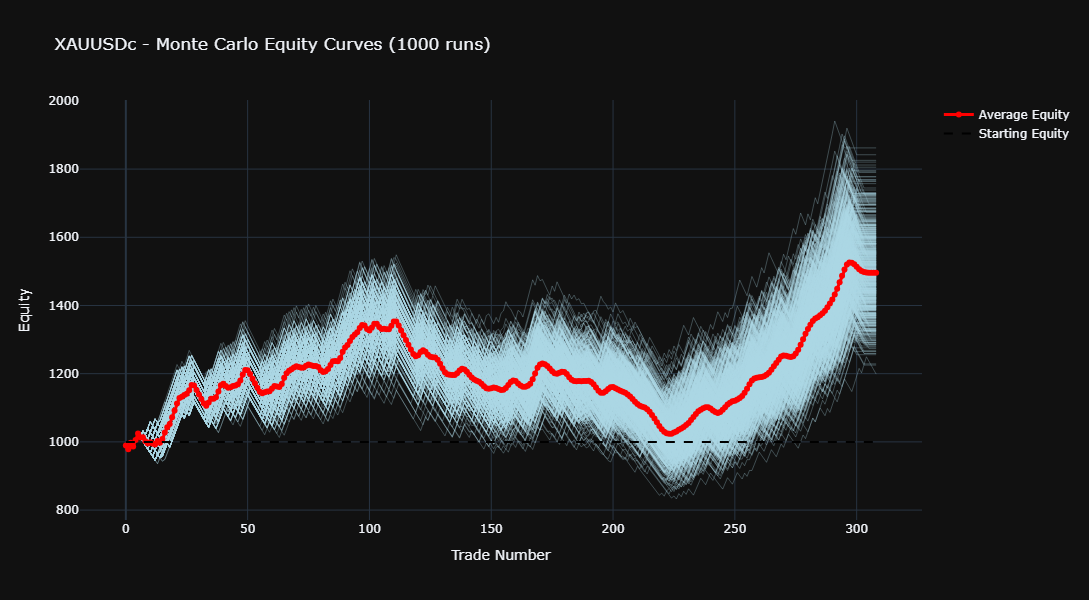

Monte Carlo Results (1000 runs):
Mean Final Equity: 1495.81
Median Final Equity: 1489.87
Max Final Equity: 1862.12
Min Final Equity: 1198.82


In [1]:
# -----------------------------
# MONTE CARLO BACKTEST
# -----------------------------
import MetaTrader5 as mt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import random

# -----------------------------
# 0. CONFIG
# -----------------------------
symbol = "XAUUSDc"
timeframe = mt.TIMEFRAME_H1
num_candles = 6000
risk_multiplier = 2.0
risk_per_trade_pct = 0.01
commission_pct = 0.01  
spread = 0.3
slippage_max = 1     
equity_start = 1000
montecarlo_runs = 1000
verbose = False

# -----------------------------
# 1. CONNECT & FETCH
# -----------------------------
if not mt.initialize():
    raise RuntimeError("MT5 initialization failed")

rates = mt.copy_rates_from_pos(symbol, timeframe, 0, num_candles)
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df.rename(columns={'open':'Open','high':'High','low':'Low','close':'Close','tick_volume':'Volume'}, inplace=True)

# -----------------------------
# 2. CALC DELTA
# -----------------------------
df['Delta'] = df.apply(lambda r: r['Volume'] if r['Close']>r['Open'] else (-r['Volume'] if r['Close']<r['Open'] else 0), axis=1)

# -----------------------------
# 3. BUILD DAILY UTC 12->13 BOXES
# -----------------------------
df_utc = df.copy()
df_utc.index = df_utc.index.tz_localize('UTC')
df_utc['Date'] = df_utc.index.date

session_boxes = []
for day, day_df in df_utc.groupby('Date'):
    session_df = day_df[(day_df.index.hour == 12)]
    if len(session_df) == 0:
        continue
    session_high = session_df['High'].max()
    session_low  = session_df['Low'].min()
    session_start = session_df.index[0]
    session_end   = session_df.index[-1]
    mid = (session_high + session_low) / 2.0
    session_boxes.append({
        'date': day,
        'start': session_start,
        'end': session_end,
        'high': session_high,
        'low': session_low,
        'mid': mid
    })

# -----------------------------
# 4. MONTE CARLO SIMULATION
# -----------------------------
final_equities = []
all_runs_equity_curves = []

for run in range(montecarlo_runs):
    trades = []
    equity = equity_start

    for box in session_boxes:

        session_end_naive = box['end'].tz_convert(None) if hasattr(box['end'], 'tzinfo') else box['end']
        try:
            start_loc = df.index.get_loc(session_end_naive)
        except KeyError:
            start_loc = df.index.searchsorted(session_end_naive)

        monitor_slice = df.iloc[start_loc+1:]
        monitor_slice = monitor_slice[monitor_slice.index.date == box['date']]
        if monitor_slice.empty:
            continue

        mid = box['mid']
        box_high = box['high']
        box_low = box['low']

        placed_pending = False
        my_pending = []

        for idx, row in monitor_slice.iterrows():

            # --- PLACE BOTH STOPS WHEN MID IS REVISITED ---
            if not placed_pending and (row['Low'] <= mid <= row['High']):
                placed_pending = True

                # Random slippage per Monte Carlo run
                slippage_buy = random.uniform(-slippage_max, slippage_max)
                slippage_sell = random.uniform(-slippage_max, slippage_max)

                # BUY STOP
                buy_entry = box_high + spread + slippage_buy
                buy_sl = mid + slippage_buy
                buy_r = abs(buy_entry - buy_sl)
                buy_tp = buy_entry + risk_multiplier * buy_r
                buy_size = (equity * risk_per_trade_pct) / buy_r

                # SELL STOP
                sell_entry = box_low - spread + slippage_sell
                sell_sl = mid + slippage_sell
                sell_r = abs(sell_entry - sell_sl)
                sell_tp = sell_entry - risk_multiplier * sell_r
                sell_size = (equity * risk_per_trade_pct) / sell_r

                my_pending = [
                    {'side':'buystop', 'entry':buy_entry, 'sl':buy_sl, 'tp':buy_tp, 'size':buy_size, 'activated':False},
                    {'side':'sellstop','entry':sell_entry,'sl':sell_sl,'tp':sell_tp,'size':sell_size,'activated':False}
                ]
                continue

            # EXECUTE TRIGGERS
            for po in my_pending:
                if po['activated']:
                    continue

                pos_idx = monitor_slice.index.get_loc(idx)
                exit_price = None
                exit_time = None

                # BUY STOP TRIGGERED
                if po['side'] == 'buystop' and row['High'] >= po['entry']:
                    entry_price = po['entry']
                    sl = po['sl']
                    tp = po['tp']
                    for j in range(pos_idx, len(monitor_slice)):
                        r2 = monitor_slice.iloc[j]
                        if r2['High'] >= tp:
                            exit_price = tp
                            exit_time = monitor_slice.index[j]
                            break
                        if r2['Low'] <= sl:
                            exit_price = sl
                            exit_time = monitor_slice.index[j]
                            break
                    if exit_price is None:
                        exit_time = monitor_slice.index[-1]
                        exit_price = monitor_slice.iloc[-1]['Close']

                    pnl = (exit_price - entry_price - spread) * po['size']
                    pnl = pnl*(1-commission_pct) if pnl>0 else pnl*(1+commission_pct)
                    trades.append(pnl)
                    equity += pnl
                    po['activated'] = True

                # SELL STOP TRIGGERED
                elif po['side'] == 'sellstop' and row['Low'] <= po['entry']:
                    entry_price = po['entry']
                    sl = po['sl']
                    tp = po['tp']
                    for j in range(pos_idx, len(monitor_slice)):
                        r2 = monitor_slice.iloc[j]
                        if r2['Low'] <= tp:
                            exit_price = tp
                            exit_time = monitor_slice.index[j]
                            break
                        if r2['High'] >= sl:
                            exit_price = sl
                            exit_time = monitor_slice.index[j]
                            break
                    if exit_price is None:
                        exit_time = monitor_slice.index[-1]
                        exit_price = monitor_slice.iloc[-1]['Close']

                    pnl = (entry_price - exit_price - spread) * po['size']
                    pnl = pnl*(1-commission_pct) if pnl>0 else pnl*(1+commission_pct)
                    trades.append(pnl)
                    equity += pnl
                    po['activated'] = True

            if all(po['activated'] for po in my_pending) and len(my_pending)>0:
                break

        my_pending = []
        placed_pending = False

    final_equities.append(equity)
    all_runs_equity_curves.append(pd.Series(trades).cumsum() + equity_start)

# -----------------------------
# 5. REPORT MONTE CARLO RESULTS
# -----------------------------
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# -----------------------------
# Convert all_runs_equity_curves to DataFrame
# -----------------------------
# Each row = trade number, each column = run
equity_df = pd.DataFrame(all_runs_equity_curves).T.fillna(method='ffill')

# Compute average equity across all runs
average_equity = equity_df.mean(axis=1)

# -----------------------------
# Plot Monte Carlo Simulation
# -----------------------------
fig = go.Figure()

# Plot individual runs as light lines
for col in equity_df.columns:
    fig.add_trace(go.Scatter(
        y=equity_df[col],
        mode='lines',
        line=dict(color='lightblue', width=1),
        opacity=0.3,
        showlegend=False
    ))

# Plot average equity curve prominently
fig.add_trace(go.Scatter(
    y=average_equity,
    mode='lines+markers',
    line=dict(color='red', width=3),
    name='Average Equity'
))

# Starting equity line
fig.add_trace(go.Scatter(
    y=[equity_start]*len(average_equity),
    mode='lines',
    line=dict(color='black', width=2, dash='dash'),
    name='Starting Equity'
))

fig.update_layout(
    template='plotly_dark',
    title=f"{symbol} - Monte Carlo Equity Curves ({montecarlo_runs} runs)",
    xaxis_title='Trade Number',
    yaxis_title='Equity',
    height=600,
    width=1000
)

fig.show()

# -----------------------------
# Print Monte Carlo stats
# -----------------------------
print(f"Monte Carlo Results ({montecarlo_runs} runs):")
print(f"Mean Final Equity: {np.mean(final_equities):.2f}")
print(f"Median Final Equity: {np.median(final_equities):.2f}")
print(f"Max Final Equity: {np.max(final_equities):.2f}")
print(f"Min Final Equity: {np.min(final_equities):.2f}")



In [2]:
# -----------------------------
# EXPORT AVERAGE EQUITY CURVE TO CSV
# -----------------------------

# Prepare DataFrame with trade number and average equity
avg_equity_df = pd.DataFrame({
    'Trade_Number': range(1, len(average_equity)+1),
    'Average_Equity': average_equity.values
})

# Save to CSV
csv_filename = '1HRMRSS_MCS1000_UTC12-13_avg_equity.csv'
avg_equity_df.to_csv(csv_filename, index=False)

print(f"Average equity curve saved to '{csv_filename}'")


Average equity curve saved to '1HRMRSS_MCS1000_UTC12-13_avg_equity.csv'
